In [1]:
import pandas as pd
from model.ep import SparseEP
from model.ep_hetero import SparseEPHetero
import torch
import matplotlib.pyplot as plt
import pyro.contrib.gp as gp
import pyro
import seaborn as sns


In [2]:
# Data taken from https://github.com/jenfly/opsd.
url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
data = pd.read_csv(url,sep=",")

C:\Users\maria\AppData\Local\Temp\ipykernel_24828\4260161993.py:6: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  wind=wind.fillna(wind.rolling(window_size+1, min_periods=1).mean());


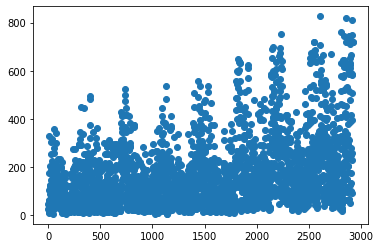

In [3]:
wind = data[["Date", "Wind"]]
wind = wind[-2922:]
date= wind.Date

window_size = 5
wind=wind.fillna(wind.rolling(window_size+1, min_periods=1).mean());
X= torch.tensor(wind["Wind"].values)
plt.scatter(torch.arange(len(X)),X)

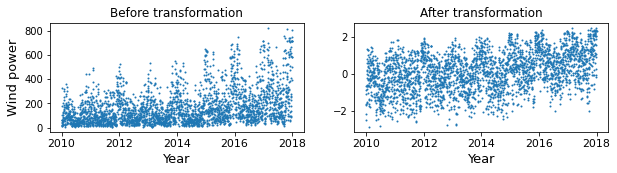

In [4]:
#Now we must rescale the data for efficient training.
scale = 5
Y_l = torch.log(X/scale + 1)
X_l = torch.arange(len(Y_l)).float()
X_train = X_l[:2500]; y_train = Y_l[:2500]; X_test = X_l[2500:]; y_test = Y_l[2500:]
mean_x = X_train.mean(); std_x = X_train.std()
mean_y = y_train.mean(); std_y = y_train.std()
X_train = (X_train-mean_x)/std_x
y_train = (y_train-mean_y)/std_y
X_test = (X_test-mean_x)/std_x
y_test = (y_test-mean_y)/std_y
X_tot = (X_l-mean_x)/std_x
y_tot = (Y_l-mean_y)/std_y
X_val = X_tot[0::10].clone()
M = len(X_val)
fig, axs  =plt.subplots(1,2,figsize = (10,2))
axs[1].scatter(X_tot,y_tot, s = 1)
axs[0].scatter(X_tot,X, s = 1)
axs[0].set_title("Before transformation")
axs[1].set_title("After transformation")

ticks = [X_tot[0].item(), X_tot[365*2].item(),  X_tot[365*4 + 1].item(),  X_tot[365*6 + 1].item(),  X_tot[365*8 + 1].item()]

axs[0].set_xticks(ticks, ['2010','2012','2014', '2016','2018'], fontsize = 11);
axs[1].set_xticks(ticks, ['2010','2012','2014', '2016','2018'], fontsize = 11);

axs[0].set_ylabel("Wind power", fontsize = 13)
axs[0].set_xlabel("Year", fontsize = 13)
axs[1].set_xlabel("Year", fontsize = 13);

In [5]:
#lets train an elliptical process with elliptical likelihood. We use a combination of a linear and periodic kernel.

x_dim = 1
Xu = torch.linspace(X_train.min(), X_train.max(), 300)

kernel_lin = gp.kernels.Linear(input_dim=x_dim, variance=torch.tensor(0.01))
kernel_cos = gp.kernels.Periodic(input_dim=1,period=torch.tensor(0.5))
kernel = gp.kernels.Sum(kernel_cos, kernel_lin)

epr = SparseEP(X = X_train,
               y = None,
                Xu = Xu, 
                kernel = kernel)


In [6]:
lr = 0.002
opt_params = [{"params": epr.parameters(), "lr": 2e-3},
                {"params": epr.likelihood.get_parameters(), "lr":0.5e-3}]

optimizer = torch.optim.Adam(opt_params)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

In [7]:
for i in range(400):
    optimizer.zero_grad()
    epr.set_data(X_train, y_train.reshape(-1))

    loss = loss_fn(epr.model, epr.guide)
    loss.backward()
    optimizer.step()
    epr.likelihood.reset()
    epr.spline_guide_xi.clear_cache()
    if i%20==0 and i > 0:
        y_pred , var, xi = epr(X_train)
        ll = epr.estimate_predictive_log_prob(X_test,y_test.flatten()).item()
        print(ll)

c:\Users\maria\Documents\Projects\Variational elliptical process\VariationalEP\model\utils.py:62: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2121.)
  W = Kfs.triangular_solve(Lff, upper=False)[0].t()


-697.6109202643722
-714.8819143123295
-703.2360353366421
-696.7078171706942
-680.1874234095421
-662.2291504809441
-704.7501352058241
-632.7536378383635
-619.1807005848913
-616.3830884743759
-608.3642988727064
-626.8025180903984
-618.5009971545162
-614.3277304048681
-594.8231588229644
-594.9555044230618
-592.237330356964
-590.3528845938858
-589.374060434915


In [8]:
# We derive credible regions by takning samples of the mixing distribution.

N = 10000
q_xi = epr.get_qxi()

xi_samp = q_xi.sample((M,N))

w_samp = epr.likelihood.elliptical_distribution.sample_pw((M,N)).squeeze().detach()

y_val, var_val, xi = epr(X_val.reshape(-1,1))
y_val = y_val.detach()
var_val = var_val.detach()#.numpy()

variances = var_val.reshape(-1,1)*xi_samp.squeeze()+ w_samp
conf = torch.normal(y_val.reshape(-1,1).repeat(1,N), torch.sqrt(variances))
c, _ = conf.sort(dim = 1)

ind_high = N-int(5/2/100*N)
ind_low = int(5/2/100*N)
c, _ = conf.sort(dim = 1)

low_c_95 = c[:,ind_low]; high_c_95 = c[:,ind_high]

confidence = epr.derive_confidence()


(-1.81, 2.31)

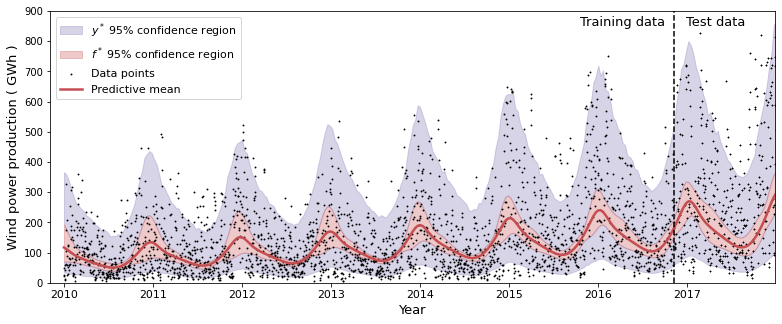

In [9]:
fig = plt.figure(figsize=(13,5))

colors = sns.color_palette("deep")

plt.fill_between(X_val,
                 (torch.exp(high_c_95*std_y + mean_y)-1)*scale,
(torch.exp((y_val+torch.sqrt(var_val)*confidence[95])*std_y + mean_y)-1)*scale,          
                 color = colors[4], alpha = 0.3 )
plt.fill_between(X_val,
                (torch.exp((y_val-torch.sqrt(var_val)*confidence[95])*std_y + mean_y)-1)*scale,
                 (torch.exp(low_c_95*std_y + mean_y)-1)*scale, 
                 color = colors[4], alpha = 0.3 , label = r"$y^*$ $95\%$ confidence region")

plt.fill_between(X_val,
                 (torch.exp((y_val-torch.sqrt(var_val)*confidence[95])*std_y + mean_y)-1)*scale,
                 (torch.exp((y_val+torch.sqrt(var_val)*confidence[95])*std_y + mean_y)-1)*scale, 
                 color = colors[3], alpha = 0.3 , label = r"$f^*$ $95\%$ confidence region")

plt.scatter(X_train,
            (torch.exp(y_train.detach()*std_y + mean_y)-1)*scale,
            s = 0.8, color = "black", label = "Data points")

plt.scatter(X_test, (torch.exp(y_test*std_y + mean_y)-1)*scale, marker = "x",
            zorder = 1, color = "black", s = 0.8)
plt.plot(X_val,(torch.exp(y_val*std_y + mean_y)-1)*scale,color = colors[3], linewidth = 2.5, label = "Predictive mean")



ticks = [X_tot[0].item(), X_tot[365].item(), X_tot[365*2].item(), X_tot[365*3 + 1].item(),  X_tot[365*4 + 1].item(),  X_tot[365*5 + 1].item(),  X_tot[365*6 + 1].item(),  X_tot[365*7 + 1].item(),  X_tot[365*8 + 1].item()]

plt.xticks(ticks, ['2010', '2011','2012','2013', '2014', '2015','2016','2017','2018'], fontsize = 11)

plt.xlabel("Year", fontsize = 13)
plt.ylabel("Wind power production ( GWh )", fontsize = 13)
plt.axvline(x = 1.7324, color = 'k', linestyle = '--')
plt.text(1.8,850, "Test data",fontsize = 13)
plt.text(1.2,850, "Training data",fontsize = 13)

plt.legend(fontsize = 11)
plt.ylim(0,900)
plt.xlim(-1.81,2.31)

In [10]:
pyro.clear_param_store()


# Now, we model the data with heteroscedastic elliptical noise, where the noise depends on the time of the year. 

Xu = torch.linspace(X_train.min(), X_train.max(), 300)
device = "cuda"
kernel_lin = gp.kernels.Linear(input_dim=1, variance=torch.tensor(0.01)).to(device)
kernel_cos = gp.kernels.Periodic(input_dim=1,period=torch.tensor(0.5)).to(device)
kernel = gp.kernels.Sum(kernel_cos, kernel_lin).to(device)
epr = SparseEPHetero(X = X_train.clone().to(device).reshape(-1,1).to(device),
                                y = None,
                                Xu = Xu.to(device).to(device), 
                                kernel = kernel.to(device), 
                                device = device,
                                jitter = 1e-3,
                                x_dim = 2).to(device)


In [11]:
# We derive the input to the heteriscedastic noise. It depends on the time of the year.

day  =  pd.to_datetime(wind["Date"]).dt.day_of_year.values
day_cos = torch.cos(torch.tensor(day/365))
day_sin = torch.sin(torch.tensor(day/365))
date_ = torch.column_stack([day_cos,day_sin])
d_train = torch.tensor(date_[:2500], dtype=torch.float32)
d_train = (d_train-d_train.mean())/d_train.std()
d_test = torch.tensor(date_[2500:], dtype=torch.float32)
d_test = (d_test-d_train.mean())/d_train.std()

d_val = (torch.tensor(date_, dtype = torch.float32)-d_train.mean())/d_train.std()
d_val = d_val[0::10].clone()



C:\Users\maria\AppData\Local\Temp\ipykernel_24828\3944357526.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_train = torch.tensor(date_[:2500], dtype=torch.float32)
C:\Users\maria\AppData\Local\Temp\ipykernel_24828\3944357526.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_test = torch.tensor(date_[2500:], dtype=torch.float32)
C:\Users\maria\AppData\Local\Temp\ipykernel_24828\3944357526.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_val = (torch.tensor(date_, dtype = torch.float32)-d_train.mean())/d_train.std()


In [12]:
opt_params = [{"params": epr.parameters(), "lr": 1e-3},
        {"params": epr.likelihood.get_parameters(), "lr":1e-5}]

optimizer = torch.optim.Adam(opt_params)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

In [13]:
epr.set_data(X_train.to(device), y_train.reshape(-1).to(device))
epr.het_in = d_train.to(device)

for i in range(400):
    optimizer.zero_grad()
    loss = loss_fn(epr.model, epr.guide)
    loss.backward()
    optimizer.step()
    epr.likelihood.reset()
    epr.spline_guide_xi.clear_cache()
    if i%20==0 and i > 0:
        y_pred , var,_ = epr(X_train.to(device))

        ll = epr.estimate_predictive_log_prob(X_test.to(device),y_test.flatten().to(device), d_test.to(device)).item()
        print(ll)

-841.9042235274584
-816.6761081592704
-795.8660723080839
-772.9900908137425
-753.4650394068267
-732.3969248001615
-714.2872416222381
-695.3700549739162
-681.3245815290578
-666.222220462756
-652.570430028924
-642.4075683876072
-632.9558023668045
-622.3950923742946
-617.9954306863835
-610.4786798329105
-607.7097582922495
-601.4407139497933
-598.6228984538584


In [14]:
# We derive credible regions by takning samples of the mixing distributions.

y_pred_dep, var_dep,_ = epr(X_val.reshape(-1,1).to(device))
conf_list = [95]
confs_y_pred = []
for i,x_ in enumerate(X_val):
    epr.likelihood.elliptical_distribution.X = d_val[i].reshape(-1,2).to(device)
    epr.likelihood.elliptical_distribution.loc = y_pred_dep[i]
    epr.likelihood.elliptical_distribution.var = var_dep[i]
    samples = epr.likelihood.elliptical_distribution.sample_pw(torch.Size([10000])).flatten()
    samples_qxi = epr.get_q_xi()(torch.Size([10000])).flatten().detach().cpu()

    samples = torch.normal(y_pred_dep[i].detach().cpu(), torch.sqrt(var_dep[i].detach().cpu()*samples_qxi + samples.detach().cpu()))
    samples,_ = torch.sort(samples)
    ind_high = len(samples)-int(5/2/100*len(samples))
    ind_low = int(5/2/100*len(samples))

    c_high = samples[ind_high]
    c_low = samples[ind_low]
    z = (torch.abs(c_high-y_pred_dep[i]) + torch.abs(c_low-y_pred_dep[i]))/2
    confs_y_pred.append(z.item())
confs_y_pred = torch.tensor(confs_y_pred).to(device)

(-1.74, 2.31)

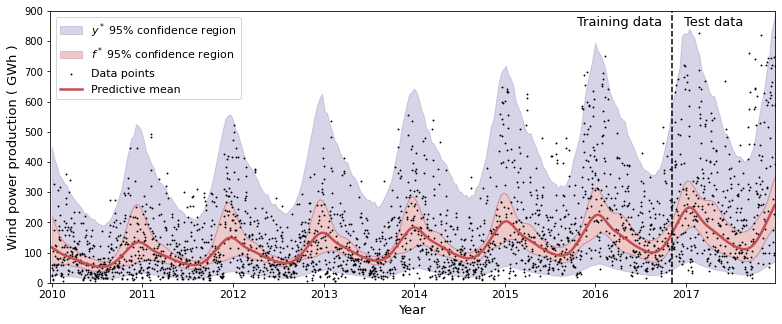

In [15]:
fig = plt.figure(figsize=(13,5))
colors = sns.color_palette("deep")

plt.fill_between(X_val,
                 (torch.exp((y_pred_dep + confs_y_pred)*std_y + mean_y)-1).detach().cpu()*scale,
                (torch.exp((y_pred_dep+torch.sqrt(var_dep)*confidence[95])*std_y + mean_y)-1).detach().cpu()*scale,          
                 color = colors[4], alpha = 0.3 )
plt.fill_between(X_val,
                (torch.exp((y_pred_dep-torch.sqrt(var_dep)*confidence[95])*std_y + mean_y)-1).detach().cpu()*scale,
                 (torch.exp((y_pred_dep - confs_y_pred)*std_y + mean_y)-1).detach().cpu()*scale, 
                 color = colors[4], alpha = 0.3 , label = r"$y^*$ $95\%$ confidence region")

plt.fill_between(X_val,
                 (torch.exp((y_pred_dep-torch.sqrt(var_dep)*confidence[95])*std_y + mean_y)-1).detach().cpu()*scale,
                 (torch.exp((y_pred_dep+torch.sqrt(var_dep)*confidence[95])*std_y + mean_y)-1).detach().cpu()*scale, 
                 color = colors[3], alpha = 0.3 , label = r"$f^*$ $95\%$ confidence region")

plt.scatter(X_train,
            (torch.exp(y_train.detach()*std_y + mean_y)-1)*scale,
            s = 0.8, color = "black", label = "Data points")

plt.scatter(X_test, (torch.exp(y_test*std_y + mean_y)-1)*scale,
            zorder = 1, color = "black", s = 0.8)
            
plt.plot(X_val.detach().cpu(),(torch.exp(y_pred_dep*std_y + mean_y)-1).detach().cpu()*scale,color = colors[3], linewidth = 2.5, label = "Predictive mean")



ticks = [X_tot[0].item(), X_tot[365].item(), X_tot[365*2].item(), X_tot[365*3 + 1].item(),  
        X_tot[365*4 + 1].item(),  X_tot[365*5 + 1].item(),  X_tot[365*6 + 1].item(),  X_tot[365*7 + 1].item(),  
        X_tot[365*8 + 1].item()]

plt.xticks(ticks, ['2010', '2011','2012','2013', '2014', '2015','2016','2017','2018'], fontsize = 11)

plt.xlabel("Year", fontsize = 13)
plt.ylabel("Wind power production ( GWh )", fontsize = 13)
plt.axvline(x = 1.7324, color = 'k', linestyle = '--')
plt.text(1.8,850, "Test data",fontsize = 13)
plt.text(1.2,850, "Training data",fontsize = 13)

plt.legend(fontsize = 11)
plt.ylim(0,900)
plt.xlim(-1.74,2.31)
